# Import block

pip install

In [ ]:
!pip install gdown --quiet
!pip install rasterio --quiet
!pip install tensorflow  --quiet
!pip install segmentation-models-pytorch  --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.4 MB/s eta 0:00:00


import

In [ ]:
import os
import tensorflow as tf
import gdown
import zipfile
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import random

sub import

In [ ]:
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from segmentation_models_pytorch.losses import DiceLoss

# Downloading the data

In [ ]:
folder_url = "https://drive.google.com/file/d/13Fx0DRAu5356ke765ZXUhfoJ-kLVc5LO/view?usp=sharing"
output = "satellite_data.zip"
gdown.download(folder_url, output, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=13Fx0DRAu5356ke765ZXUhfoJ-kLVc5LO
From (redirected): https://drive.google.com/uc?id=13Fx0DRAu5356ke765ZXUhfoJ-kLVc5LO&confirm=t&uuid=11bb2d2e-2ba7-4d37-8eeb-663900461e97
To: /content/satellite_data.zip
100%|██████████| 68.8M/68.8M [00:00<00:00, 110MB/s]


'satellite_data.zip'

unzip

In [ ]:
with zipfile.ZipFile(output) as zip_ref:
    zip_ref.extractall("satellite_data")

Storing in directories

In [ ]:
data_directory = "satellite_data/satalite data/data"
images_directory = os.path.join(data_directory, "images")
labels_directory = os.path.join(data_directory, "labels")

checking directories

In [ ]:
print("Images directory:", images_directory)
print("Labels directory:", labels_directory)

Images directory: satellite_data/satalite data/data/images
Labels directory: satellite_data/satalite data/data/labels


# Data processing

In [ ]:
tif_files = [os.path.join(images_directory, f) for f in os.listdir(images_directory) if f.endswith(".tif")]
png_files = [os.path.join(labels_directory, f) for f in os.listdir(labels_directory) if f.endswith(".png")]

sort function

In [ ]:
def extract_number(filename):
    return int(os.path.splitext(os.path.basename(filename))[0])

sorting application

In [ ]:
tif_files_sorted = sorted(tif_files, key=extract_number)
png_files_sorted = sorted(png_files, key=extract_number)

check data

In [ ]:
for i in range(5):  # preview first 5 pairs
    print(f"Image: {tif_files_sorted[i]}  |  Mask: {png_files_sorted[i]}")

Image: satellite_data/satalite data/data/images/0.tif  |  Mask: satellite_data/satalite data/data/labels/0.png
Image: satellite_data/satalite data/data/images/1.tif  |  Mask: satellite_data/satalite data/data/labels/1.png
Image: satellite_data/satalite data/data/images/2.tif  |  Mask: satellite_data/satalite data/data/labels/2.png
Image: satellite_data/satalite data/data/images/3.tif  |  Mask: satellite_data/satalite data/data/labels/3.png
Image: satellite_data/satalite data/data/images/4.tif  |  Mask: satellite_data/satalite data/data/labels/4.png


optional arrays

In [ ]:
images_files = np.array(tif_files_sorted)
labels_files = np.array(png_files_sorted)

opening data

In [ ]:
all_images = []
all_masks = []
for tif_path, mask_path in zip(tif_files_sorted, png_files_sorted):
    with rasterio.open(tif_path) as source:
        image = source.read()
        image = np.transpose(image, (1,2,0))
    all_images.append(image)
    mask = np.array(Image.open(mask_path))
    all_masks.append(mask)
all_images = np.array(all_images)
all_masks = np.array(all_masks)

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


preview

In [ ]:
print("Images shape:", all_images.shape)
print("Masks shape:", all_masks.shape)

Images shape: (306, 128, 128, 12)
Masks shape: (306, 128, 128)


normalization start

In [ ]:
band_mins = all_images.reshape(-1, all_images.shape[-1]).min(axis=0)
band_maxs = all_images.reshape(-1, all_images.shape[-1]).max(axis=0)
mask_min = all_masks.min()
mask_max = all_masks.max()

preview

In [ ]:
print("Band mins:", band_mins)
print("Band maxs:", band_maxs)
print("Mask min:", mask_min)
print("Mask max:", mask_max)

Band mins: [-1393 -1169  -722  -684  -412  -335  -258    64 -9999     8    10     0]
Band maxs: [ 6568  9659 11368 12041 15841 15252 14647   255  4245  4287   100   111]
Mask min: 0
Mask max: 1


normalization

In [ ]:
images_norm = (all_images - band_mins) / (band_maxs - band_mins)
masks_norm = (all_masks - mask_min) / (mask_max - mask_min)

review

In [ ]:
print("Normalized images shape:", images_norm.shape)
print("Normalized masks shape:", masks_norm.shape)

Normalized images shape: (306, 128, 128, 12)
Normalized masks shape: (306, 128, 128)


# Best channel selection

In [ ]:
num_bands = images_norm.shape[-1]
pcc_scores = []
mse_scores = []
ssim_scores = []
for b in range(num_bands):
    band_values = images_norm[..., b]
    band_values_flat = band_values.reshape(-1)
    mask_values_flat = masks_norm.reshape(-1)
    pcc = np.corrcoef(band_values_flat, mask_values_flat)[0,1]
    mse = np.mean((band_values_flat- mask_values_flat) ** 2)
    ssim_per_image = []
    for i in range(images_norm.shape[0]):
        ssim_value = ssim(band_values[i], masks_norm[i], data_range=1.0)
        ssim_per_image.append(ssim_value)
    ssim_average = np.mean(ssim_per_image)
    pcc_scores.append(pcc)
    mse_scores.append(mse)
    ssim_scores.append(ssim_average)

convert to arrays

In [ ]:
pcc_scores = np.array(pcc_scores)
mse_scores = np.array(mse_scores)
ssim_scores = np.array(ssim_scores)

band ranking (high pcc, low mse, high ssim)

In [ ]:
combined_score = pcc_scores - mse_scores + ssim_scores
best_indices = np.argsort(-combined_score)

results

In [ ]:
print("Band ranking by combined score:")
for idx in best_indices:
    print(f"Band {idx} | PCC={pcc_scores[idx]:.3f}, MSE={mse_scores[idx]:.3f}, SSIM={ssim_scores[idx]:.3f}")
top3 = best_indices[:3]
print("Top 3 bands:", top3)

Band ranking by combined score:
Band 11 | PCC=0.508, MSE=0.174, SSIM=0.679
Band 7 | PCC=0.247, MSE=0.206, SSIM=0.383
Band 10 | PCC=0.419, MSE=0.161, SSIM=0.163
Band 2 | PCC=0.003, MSE=0.212, SSIM=0.045
Band 1 | PCC=-0.025, MSE=0.206, SSIM=0.052
Band 0 | PCC=-0.065, MSE=0.197, SSIM=0.071
Band 3 | PCC=-0.028, MSE=0.213, SSIM=0.044
Band 9 | PCC=-0.177, MSE=0.262, SSIM=0.130
Band 8 | PCC=-0.254, MSE=0.427, SSIM=0.150
Band 6 | PCC=-0.416, MSE=0.244, SSIM=0.018
Band 5 | PCC=-0.509, MSE=0.246, SSIM=0.014
Band 4 | PCC=-0.564, MSE=0.241, SSIM=0.018
Top 3 bands: [11  7 10]


# Model

defining the dataset

In [ ]:
class SatelliteDataset(Dataset):
    def __init__(self, images, masks, augment=False):
        self.images = images
        self.masks = masks
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # (H,W,3)
        mask = self.masks[idx]    # (H,W) or (H,W,1)

        # convert to tensor
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # (3,H,W)
        mask = torch.tensor(mask, dtype=torch.float32)
        if mask.ndim == 3:  # remove trailing channel if exists
            mask = mask.squeeze(-1)
        mask = mask.unsqueeze(0)  # (1,H,W)

        # augmentation
        if self.augment:
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            if random.random() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
            if random.random() > 0.5:
                angle = random.choice([0, 90, 180, 270])
                image = TF.rotate(image, angle)
                mask = TF.rotate(mask, angle)

        return image, mask


splitting the data

In [ ]:
images_top3 = images_norm[..., top3]
masks = masks_norm[..., np.newaxis]
train_images_top3, val_images_top3, train_masks, val_masks = train_test_split(
    images_top3,
    masks,
    test_size=0.2,
    random_state=42)

review

In [ ]:
print("Train images:", train_images_top3.shape)
print("Val images:", val_images_top3.shape)
print("Train masks:", train_masks.shape)
print("Val masks:", val_masks.shape)

Train images: (244, 128, 128, 3)
Val images: (62, 128, 128, 3)
Train masks: (244, 128, 128, 1)
Val masks: (62, 128, 128, 1)


data loaders

In [ ]:
train_dataset = SatelliteDataset(train_images_top3, train_masks, augment=True)
val_dataset   = SatelliteDataset(val_images_top3, val_masks, augment=False)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4)

pretrained model

In [70]:
model = smp.Unet(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1)
for name, param in model.encoder.named_parameters():
    param.requires_grad = True
loss_fn = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss(mode='binary')
bce_loss  = nn.BCEWithLogitsLoss()

def criterion(outputs, targets):
    return bce_loss(outputs, targets) + dice_loss(outputs, targets)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

training

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
num_epochs = 50
train_losses = []
val_losses = []
val_ious = []
best_iou = 0.0
best_model_path = "best_model.pth"

def iou_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum((1, 2, 3))
    union = preds.sum((1, 2, 3)) + targets.sum((1, 2, 3)) - intersection
    return (intersection.float() / (union.float() + 1e-6)).mean().item()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    total_iou = 0.0
    count = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

            preds = torch.sigmoid(outputs)
            batch_iou = iou_score(preds, masks)
            total_iou += batch_iou
            count += 1

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_iou = total_iou / count

    # Save best model
    if avg_val_iou > best_iou:
        best_iou = avg_val_iou
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with IoU {best_iou:.4f}")

    val_losses.append(avg_val_loss)
    val_ious.append(avg_val_iou)

    print(f"Epoch {epoch + 1}/{num_epochs} "
          f"- Train Loss: {epoch_loss:.4f} "
          f"- Val Loss: {avg_val_loss:.4f} "
          f"- Val IoU: {avg_val_iou:.4f}")


Epoch 1/50: 100%|██████████| 61/61 [00:04<00:00, 15.13it/s]


New best model saved with IoU 0.2006
Epoch 1/50 - Train Loss: 0.6024 - Val Loss: 0.5710 - Val IoU: 0.2006


Epoch 2/50: 100%|██████████| 61/61 [00:03<00:00, 15.82it/s]


New best model saved with IoU 0.2193
Epoch 2/50 - Train Loss: 0.5127 - Val Loss: 0.5172 - Val IoU: 0.2193


Epoch 3/50: 100%|██████████| 61/61 [00:03<00:00, 18.19it/s]


New best model saved with IoU 0.2702
Epoch 3/50 - Train Loss: 0.4592 - Val Loss: 0.4738 - Val IoU: 0.2702


Epoch 4/50: 100%|██████████| 61/61 [00:03<00:00, 17.73it/s]


New best model saved with IoU 0.3029
Epoch 4/50 - Train Loss: 0.4282 - Val Loss: 0.4426 - Val IoU: 0.3029


Epoch 5/50: 100%|██████████| 61/61 [00:04<00:00, 13.10it/s]


Epoch 5/50 - Train Loss: 0.4041 - Val Loss: 0.4291 - Val IoU: 0.2889


Epoch 6/50: 100%|██████████| 61/61 [00:03<00:00, 18.14it/s]


New best model saved with IoU 0.3129
Epoch 6/50 - Train Loss: 0.3787 - Val Loss: 0.4402 - Val IoU: 0.3129


Epoch 7/50: 100%|██████████| 61/61 [00:03<00:00, 18.03it/s]


Epoch 7/50 - Train Loss: 0.3741 - Val Loss: 0.4339 - Val IoU: 0.2971


Epoch 8/50: 100%|██████████| 61/61 [00:03<00:00, 15.49it/s]


New best model saved with IoU 0.3249
Epoch 8/50 - Train Loss: 0.3651 - Val Loss: 0.4261 - Val IoU: 0.3249


Epoch 9/50: 100%|██████████| 61/61 [00:03<00:00, 18.18it/s]


Epoch 9/50 - Train Loss: 0.3516 - Val Loss: 0.4876 - Val IoU: 0.2822


Epoch 10/50: 100%|██████████| 61/61 [00:03<00:00, 18.01it/s]


Epoch 10/50 - Train Loss: 0.3459 - Val Loss: 0.4376 - Val IoU: 0.3122


Epoch 11/50: 100%|██████████| 61/61 [00:04<00:00, 13.72it/s]


Epoch 11/50 - Train Loss: 0.3519 - Val Loss: 0.4435 - Val IoU: 0.3014


Epoch 12/50: 100%|██████████| 61/61 [00:03<00:00, 18.12it/s]


New best model saved with IoU 0.3354
Epoch 12/50 - Train Loss: 0.3389 - Val Loss: 0.4176 - Val IoU: 0.3354


Epoch 13/50: 100%|██████████| 61/61 [00:03<00:00, 18.19it/s]


Epoch 13/50 - Train Loss: 0.3397 - Val Loss: 0.4639 - Val IoU: 0.3171


Epoch 14/50: 100%|██████████| 61/61 [00:04<00:00, 13.46it/s]


Epoch 14/50 - Train Loss: 0.3337 - Val Loss: 0.4306 - Val IoU: 0.3312


Epoch 15/50: 100%|██████████| 61/61 [00:03<00:00, 18.14it/s]


Epoch 15/50 - Train Loss: 0.3344 - Val Loss: 0.4733 - Val IoU: 0.3180


Epoch 16/50: 100%|██████████| 61/61 [00:03<00:00, 18.16it/s]


New best model saved with IoU 0.3424
Epoch 16/50 - Train Loss: 0.3223 - Val Loss: 0.4215 - Val IoU: 0.3424


Epoch 17/50: 100%|██████████| 61/61 [00:03<00:00, 15.82it/s]


Epoch 17/50 - Train Loss: 0.3198 - Val Loss: 0.4375 - Val IoU: 0.3136


Epoch 18/50: 100%|██████████| 61/61 [00:03<00:00, 17.99it/s]


Epoch 18/50 - Train Loss: 0.2984 - Val Loss: 0.4687 - Val IoU: 0.3283


Epoch 19/50: 100%|██████████| 61/61 [00:03<00:00, 18.07it/s]


Epoch 19/50 - Train Loss: 0.3079 - Val Loss: 0.5365 - Val IoU: 0.3140


Epoch 20/50: 100%|██████████| 61/61 [00:03<00:00, 16.82it/s]


Epoch 20/50 - Train Loss: 0.3142 - Val Loss: 0.4919 - Val IoU: 0.3343


Epoch 21/50: 100%|██████████| 61/61 [00:03<00:00, 17.18it/s]


Epoch 21/50 - Train Loss: 0.3016 - Val Loss: 0.4543 - Val IoU: 0.3266


Epoch 22/50: 100%|██████████| 61/61 [00:03<00:00, 18.12it/s]


New best model saved with IoU 0.3530
Epoch 22/50 - Train Loss: 0.2981 - Val Loss: 0.4309 - Val IoU: 0.3530


Epoch 23/50: 100%|██████████| 61/61 [00:03<00:00, 17.25it/s]


Epoch 23/50 - Train Loss: 0.2926 - Val Loss: 0.4539 - Val IoU: 0.3466


Epoch 24/50: 100%|██████████| 61/61 [00:03<00:00, 16.45it/s]


Epoch 24/50 - Train Loss: 0.2874 - Val Loss: 0.4353 - Val IoU: 0.3467


Epoch 25/50: 100%|██████████| 61/61 [00:03<00:00, 18.26it/s]


Epoch 25/50 - Train Loss: 0.2990 - Val Loss: 0.4852 - Val IoU: 0.3436


Epoch 26/50: 100%|██████████| 61/61 [00:03<00:00, 18.13it/s]


Epoch 26/50 - Train Loss: 0.2802 - Val Loss: 0.5422 - Val IoU: 0.3146


Epoch 27/50: 100%|██████████| 61/61 [00:03<00:00, 15.39it/s]


Epoch 27/50 - Train Loss: 0.2711 - Val Loss: 0.4511 - Val IoU: 0.3463


Epoch 28/50: 100%|██████████| 61/61 [00:03<00:00, 18.20it/s]


Epoch 28/50 - Train Loss: 0.2724 - Val Loss: 0.4903 - Val IoU: 0.3300


Epoch 29/50: 100%|██████████| 61/61 [00:03<00:00, 18.41it/s]


Epoch 29/50 - Train Loss: 0.2725 - Val Loss: 0.4781 - Val IoU: 0.3253


Epoch 30/50: 100%|██████████| 61/61 [00:03<00:00, 15.45it/s]


Epoch 30/50 - Train Loss: 0.2651 - Val Loss: 0.4889 - Val IoU: 0.3481


Epoch 31/50: 100%|██████████| 61/61 [00:03<00:00, 17.78it/s]


Epoch 31/50 - Train Loss: 0.2699 - Val Loss: 0.4908 - Val IoU: 0.3505


Epoch 32/50: 100%|██████████| 61/61 [00:03<00:00, 18.06it/s]


New best model saved with IoU 0.3607
Epoch 32/50 - Train Loss: 0.2739 - Val Loss: 0.4672 - Val IoU: 0.3607


Epoch 33/50: 100%|██████████| 61/61 [00:03<00:00, 15.45it/s]


New best model saved with IoU 0.3715
Epoch 33/50 - Train Loss: 0.2518 - Val Loss: 0.4697 - Val IoU: 0.3715


Epoch 34/50: 100%|██████████| 61/61 [00:03<00:00, 18.15it/s]


Epoch 34/50 - Train Loss: 0.2617 - Val Loss: 0.5052 - Val IoU: 0.3393


Epoch 35/50: 100%|██████████| 61/61 [00:03<00:00, 17.98it/s]


New best model saved with IoU 0.3743
Epoch 35/50 - Train Loss: 0.2574 - Val Loss: 0.4685 - Val IoU: 0.3743


Epoch 36/50: 100%|██████████| 61/61 [00:03<00:00, 15.29it/s]


Epoch 36/50 - Train Loss: 0.2652 - Val Loss: 0.5101 - Val IoU: 0.3578


Epoch 37/50: 100%|██████████| 61/61 [00:03<00:00, 18.33it/s]


Epoch 37/50 - Train Loss: 0.2441 - Val Loss: 0.4449 - Val IoU: 0.3735


Epoch 38/50: 100%|██████████| 61/61 [00:03<00:00, 18.26it/s]


Epoch 38/50 - Train Loss: 0.2578 - Val Loss: 0.4648 - Val IoU: 0.3610


Epoch 39/50: 100%|██████████| 61/61 [00:03<00:00, 15.56it/s]


Epoch 39/50 - Train Loss: 0.2514 - Val Loss: 0.5396 - Val IoU: 0.3439


Epoch 40/50: 100%|██████████| 61/61 [00:03<00:00, 17.96it/s]


Epoch 40/50 - Train Loss: 0.2387 - Val Loss: 0.5452 - Val IoU: 0.3672


Epoch 41/50: 100%|██████████| 61/61 [00:03<00:00, 18.29it/s]


Epoch 41/50 - Train Loss: 0.2440 - Val Loss: 0.5176 - Val IoU: 0.3597


Epoch 42/50: 100%|██████████| 61/61 [00:03<00:00, 15.48it/s]


Epoch 42/50 - Train Loss: 0.2353 - Val Loss: 0.5325 - Val IoU: 0.3581


Epoch 43/50: 100%|██████████| 61/61 [00:03<00:00, 18.14it/s]


New best model saved with IoU 0.3749
Epoch 43/50 - Train Loss: 0.2349 - Val Loss: 0.5367 - Val IoU: 0.3749


Epoch 44/50: 100%|██████████| 61/61 [00:03<00:00, 18.28it/s]


Epoch 44/50 - Train Loss: 0.2302 - Val Loss: 0.5260 - Val IoU: 0.3629


Epoch 45/50: 100%|██████████| 61/61 [00:03<00:00, 16.19it/s]


Epoch 45/50 - Train Loss: 0.2453 - Val Loss: 0.5455 - Val IoU: 0.3721


Epoch 46/50: 100%|██████████| 61/61 [00:03<00:00, 18.20it/s]


Epoch 46/50 - Train Loss: 0.2365 - Val Loss: 0.5119 - Val IoU: 0.3441


Epoch 47/50: 100%|██████████| 61/61 [00:03<00:00, 18.30it/s]


Epoch 47/50 - Train Loss: 0.2477 - Val Loss: 0.4419 - Val IoU: 0.3400


Epoch 48/50: 100%|██████████| 61/61 [00:03<00:00, 17.06it/s]


Epoch 48/50 - Train Loss: 0.2370 - Val Loss: 0.4617 - Val IoU: 0.3707


Epoch 49/50: 100%|██████████| 61/61 [00:03<00:00, 16.91it/s]


New best model saved with IoU 0.3810
Epoch 49/50 - Train Loss: 0.2351 - Val Loss: 0.4774 - Val IoU: 0.3810


Epoch 50/50: 100%|██████████| 61/61 [00:03<00:00, 18.14it/s]


Epoch 50/50 - Train Loss: 0.2251 - Val Loss: 0.4752 - Val IoU: 0.3527


model prediction

In [72]:
model.load_state_dict(torch.load(best_model_path))
model.eval()
images, masks = next(iter(val_loader))
images = images.to(device)
masks = masks.to(device)
with torch.no_grad():
    preds = torch.sigmoid(model(images))
preds = preds.cpu().numpy()
masks = masks.cpu().numpy()
images = images.cpu().numpy()

plot first 3 examples

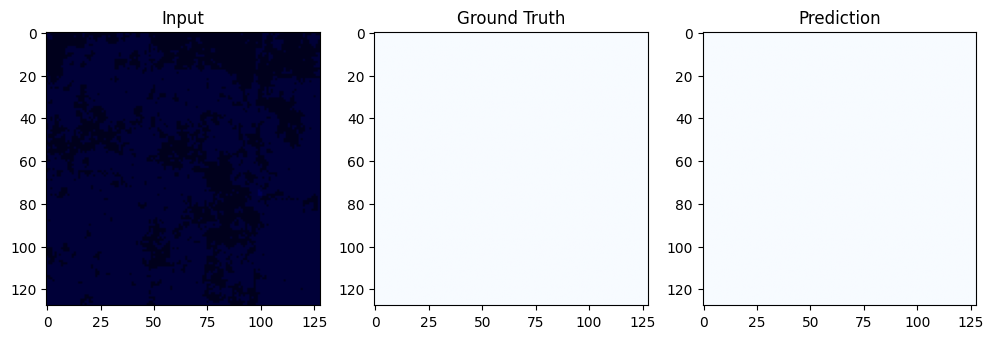

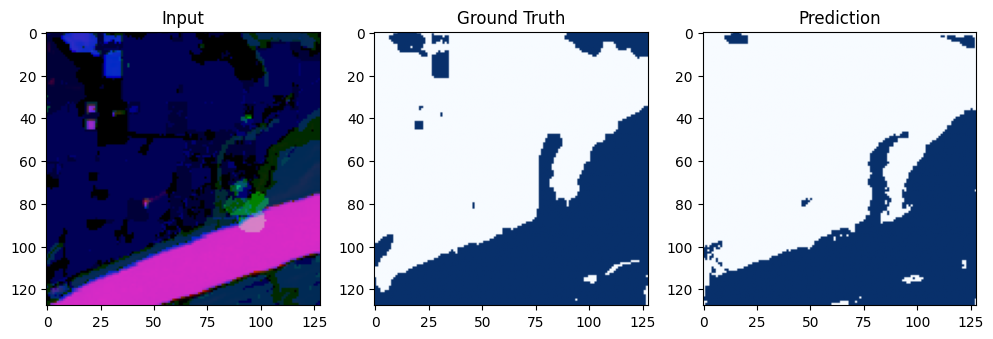

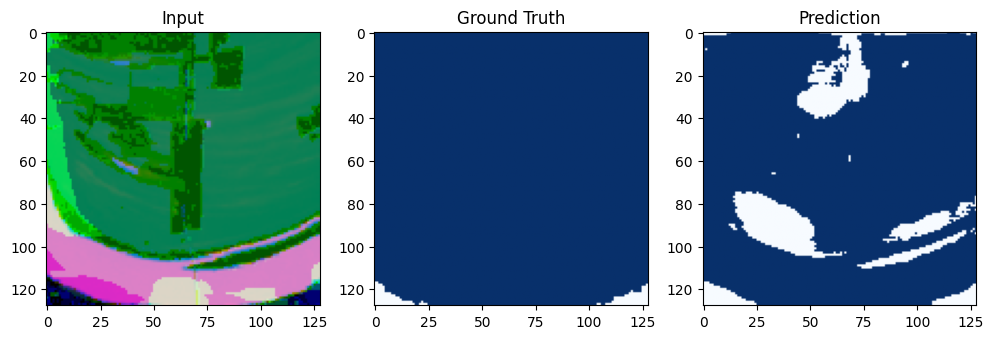

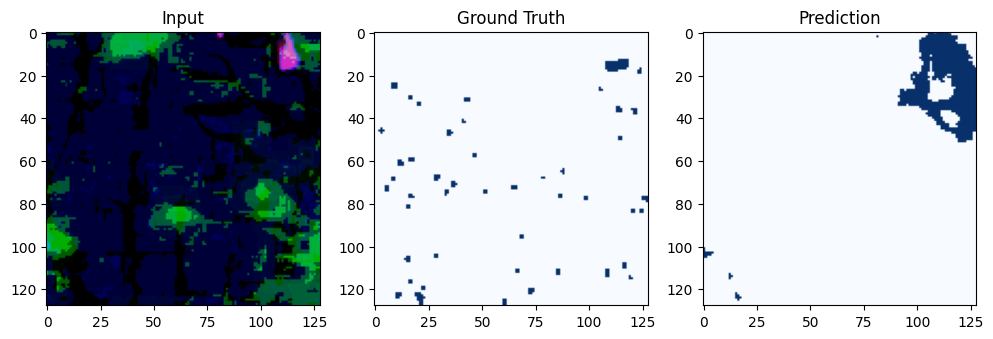

In [75]:
# get a random batch from val_loader
random_batch = random.choice(list(val_loader))
images, masks = random_batch
images = images.to(device)
masks = masks.to(device)

with torch.no_grad():
    preds = torch.sigmoid(model(images))

preds = preds.cpu().numpy()
masks = masks.cpu().numpy()
images = images.cpu().numpy()

# plot more images (for example, 6 instead of 3)
num_to_plot = min(6, images.shape[0])
for i in range(num_to_plot):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(images[i], (1,2,0)))
    plt.title("Input")
    plt.subplot(1,3,2)
    plt.imshow(masks[i,0], cmap='Blues')
    plt.title("Ground Truth")
    plt.subplot(1,3,3)
    plt.imshow(preds[i,0]>0.5, cmap='Blues')
    plt.title("Prediction")
    plt.show()


plotting

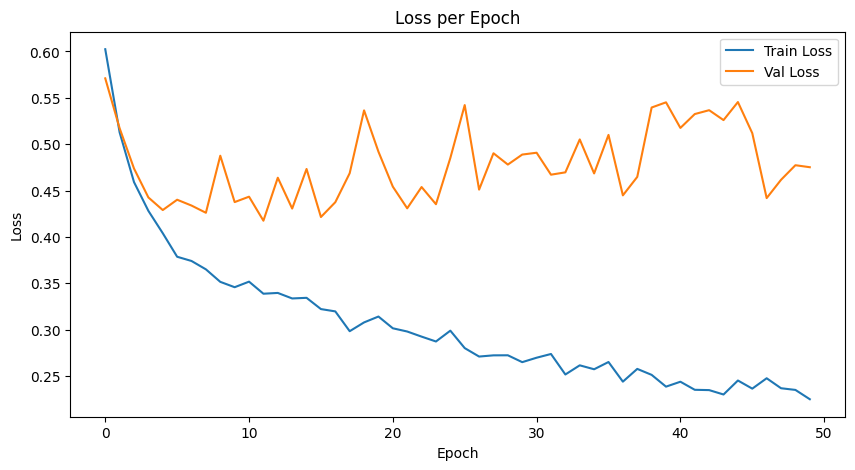

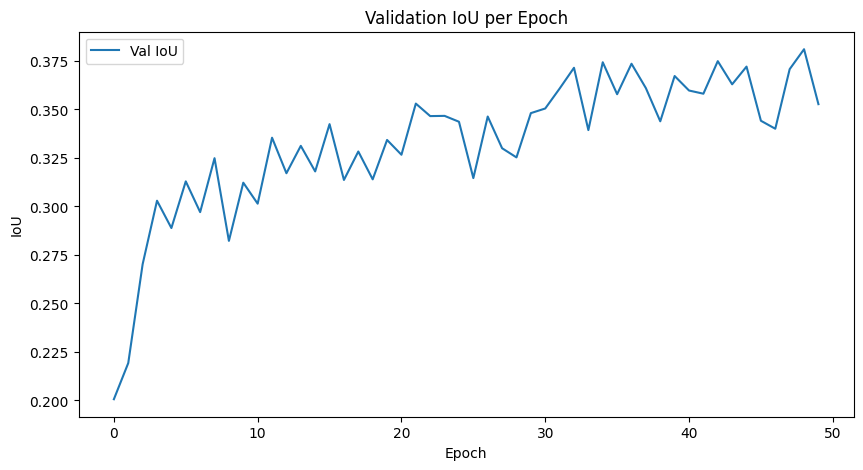

In [76]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(val_ious, label='Val IoU')
plt.title('Validation IoU per Epoch')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()
